For this homework, make sure that you format your notbook nicely and cite all sources in the appropriate sections. Programmatically generate or embed any figures or graphs that you need.

Names: __Vedanshi Shah & Arnav Joshi__

Step 1: Train your own word embeddings
--------------------------------

The provided dataset that we have chosen to use for the assignment is the Shakespeare dataset. The provided dataset has 904468 words, 29476 of which are unique (this is the vocabulary size of this corpus) when tokenized by the nltk tokenizer. Furthermore, the corpus contains 94980 sentences through the same tokenizer. The average sentence length is ~9.52 words/tokens per sentence and the average number of stop words (based on nltk's stop word library) is ~4.40 stop words per sentence, making the ratio between the two around 0.46. 

Describe what data set you have chosen to compare and contrast with the your chosen provided dataset. Make sure to describe where it comes from and it's general properties.

In contrast, the dataset we chose was the Bible in Project Gutenberg. This dataset contains 854254 words with a vocabulary size of 12755. This corpus has 30103 sentences with an average length of 28.38 words/tokens. The average number of stop words per sentence in this corpus is 13.85 words, making the ratio of stop words to other words 0.49. While the corpus is a similar size as the provided one, there are far more repeated words, making the vocabulary size less than half as large, which may be better for understanding context later. There are additionally, less than 1/3 the number of sentences, making each sentence far longer, but the number of stop words per sentence (and thus their ratio) is approximately the same.

These corpus statistics are repeated below in code.

In [1]:
# import your libraries here
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('gutenberg')

from nltk.corpus import stopwords
from nltk.corpus import gutenberg
from nltk.stem import *

from multiprocessing import cpu_count
import string
import gensim
from gensim.models import Word2Vec

from sklearn.manifold import TSNE
import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Importing utility functions from Keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
import keras
from keras import backend as K
K.get_config()

[nltk_data] Downloading package punkt to /home/arnav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/arnav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package gutenberg to /home/arnav/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
2023-03-22 19:40:39.553610: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 19:40:40.319221: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/arnav/miniconda3/lib/
2023-

device_count {
  key: "CPU"
  value: 1
}
device_count {
  key: "GPU"
  value: 1
}
gpu_options {
  visible_device_list: "0"
  experimental {
  }
}
allow_soft_placement: true
experimental {
}

### a) Train embeddings on GIVEN dataset

In [2]:
# code to train your word embeddings

# Read the file and prepare the training data 
# so that it is in the following format

data = [['this', 'is', 'the', 'first', 'sentence', 'for', 'word2vec'],
			['this', 'is', 'the', 'second', 'sentence'],
			['yet', 'another', 'sentence'],
			['one', 'more', 'sentence'],
			['and', 'the', 'final', 'sentence']]

In [3]:
# The dimension of word embedding. 
# This variable will be used throughout the program
# you may vary this as you desire
EMBEDDINGS_SIZE = 200

# Train the Word2Vec model from Gensim. 
# Below are the hyperparameters that are most relevant. 
# But feel free to explore other 
# options too:
sg = 1
window = 5
vector_size = EMBEDDINGS_SIZE
min_count = 1
workers = cpu_count()

# Whether or not we are activating stemming
stemming = False
stemmer = PorterStemmer()

# Whether or not to use stopwords
usestopwords = False
stop_words = set(stopwords.words('english'))

# Whether or not to case fold
casefold = True

# Whether or not to add sentence begin and end tokens
senttokens = False

# Whether or not to remove punctuation
removepunc = True

# The size of the ngram language model you want to train
# change as needed for your experiments
# Needed to move this up for the sentence begin and end tokens
NGRAM = 3


In [4]:
# if you save your Word2Vec as the variable model, this will 
# Train the model
model = Word2Vec(data, sg=sg, window=window, vector_size=vector_size, min_count=min_count, workers=workers)

# print out the vocabulary size
# vocab size - access the vocabulary
print("Vocabulary size:", len(model.wv.index_to_key))

Vocabulary size: 14


##### Training on the spooky author identification dataset from kaggle (unused)

In [5]:
# get the data
import pandas as pd

# then do a second data set
test = pd.read_csv('spooky-author-identification/test.csv')
train = pd.read_csv('spooky-author-identification/train.csv')

# get 50% of the test development data set
test_dev = test.sample(frac=0.5, random_state=1)
train_dev = train.sample(frac=0.5, random_state=1)

In [6]:
# For testing purposes and learning the Word2Vec models

'''
train_list_of_lists = [['<s>'] + nltk.word_tokenize(sent) + ['</s>'] for sent in train_dev['text']]

# training the word2vec model
model_w2v_spook = Word2Vec(train_list_of_lists,  sg=sg, window=window, vector_size=vector_size, min_count=min_count, workers=workers)
model_w2v_spook.train(train_list_of_lists, total_examples=1, epochs=10)

# save the word embeddings
model_w2v_spook.wv.save_word2vec_format('embeddings_spook.txt', binary=False)
'''

"\ntrain_list_of_lists = [['<s>'] + nltk.word_tokenize(sent) + ['</s>'] for sent in train_dev['text']]\n\n# training the word2vec model\nmodel_w2v_spook = Word2Vec(train_list_of_lists,  sg=sg, window=window, vector_size=vector_size, min_count=min_count, workers=workers)\nmodel_w2v_spook.train(train_list_of_lists, total_examples=1, epochs=10)\n\n# save the word embeddings\nmodel_w2v_spook.wv.save_word2vec_format('embeddings_spook.txt', binary=False)\n"

##### Training on the shakespeare dataset

In [7]:
def trainWord2Vec(listOflists, stemming=stemming, usestopwords=usestopwords, casefold=casefold, senttokens=senttokens, removepunc=removepunc, ngram=NGRAM, stemmer=stemmer, stop_words=stop_words):
    split_words = []
    for line in listOflists:
        curr_line = []
        for word in line:
            if usestopwords and word in stop_words:
                continue
            if removepunc and word in string.punctuation:
                continue
            if casefold:
                word = word.lower()
            if stemming:
                stemmer.stem(word)
            curr_line.append(word)
        if senttokens:
            curr_line = ['<s>']*(ngram-1) + curr_line + ['</s>']*(ngram-1)
        if not curr_line:
            continue
        split_words.append(curr_line)
    return Word2Vec(sentences=split_words, sg=sg, vector_size=EMBEDDINGS_SIZE, window=window, min_count=min_count, workers=workers), split_words

In [8]:
def corpus_analysis(name, split_words):
    print("Corpus analysis for", name)
    print("-"*60)
    
    num_words = sum([len(sent) for sent in split_words])
    print("Number of words:", num_words)
    vocab_size = len(set([word for sent in split_words for word in sent]))
    print("Vocabulary size:", vocab_size)
    n = len(split_words)
    print("Number of sentences:", n)
    avg_sent_len = sum([len(sent) for sent in split_words]) / n
    print("Average sentence length (of words/tokens):", avg_sent_len)
    avg_stopwords = sum([sum([1 for word in sent if word in stop_words]) for sent in split_words]) / n
    print("Average number of stopwords per sentence:", avg_stopwords)
    ratio_stopwords = avg_stopwords / avg_sent_len
    print("Average ratio of stopwords to words:", ratio_stopwords)

In [9]:
# code to train your word embeddings
training_file_path = "shakesdown.txt"

f = open(training_file_path, "r", encoding="utf-8")
# read all contents
content = f.read()
# close the file when you're done
f.close()

model_w2v_shake, shake_split_words = trainWord2Vec([nltk.word_tokenize(line) for line in nltk.sent_tokenize(content)])

model_w2v_shake.save("model_given.model")

# if you save your Word2Vec as the variable model, this will 
# print out the vocabulary size
print('Vocab size {}'.format(len(model_w2v_shake.wv)))

# You can save file in txt format, then load later if you wish.
model_w2v_shake.wv.save_word2vec_format('embeddings_shake.txt', binary=False)

Vocab size 29476


In [10]:
corpus_analysis("Shakespeare", shake_split_words)

Corpus analysis for Shakespeare
------------------------------------------------------------
Number of words: 904468
Vocabulary size: 29476
Number of sentences: 94980
Average sentence length (of words/tokens): 9.522720572752158
Average number of stopwords per sentence: 4.398894504106128
Average ratio of stopwords to words: 0.46193674071387825


### b) Train embedding on YOUR dataset

In [11]:
# Use Bible or full Gutenberg dataset?
gutenberg_ids_to_len = {id:len(gutenberg.words(id)) for id in gutenberg.fileids()}
max_id = max(gutenberg_ids_to_len, key=lambda x:gutenberg_ids_to_len[x])

bible = gutenberg.words(max_id)

print("Number of words in bible:", len(bible))

num_unique_words = len(set(bible))
print("Number of unique words in bible:", num_unique_words)

bible = gutenberg.sents(max_id)
print(bible[:5])
model_w2v_bible, bible_split_words = trainWord2Vec(bible)

model_w2v_bible.wv.save_word2vec_format('embeddings_bible.txt', binary=False)

Number of words in bible: 1010654
Number of unique words in bible: 13769
[['[', 'The', 'King', 'James', 'Bible', ']'], ['The', 'Old', 'Testament', 'of', 'the', 'King', 'James', 'Bible'], ['The', 'First', 'Book', 'of', 'Moses', ':', 'Called', 'Genesis'], ['1', ':', '1', 'In', 'the', 'beginning', 'God', 'created', 'the', 'heaven', 'and', 'the', 'earth', '.'], ['1', ':', '2', 'And', 'the', 'earth', 'was', 'without', 'form', ',', 'and', 'void', ';', 'and', 'darkness', 'was', 'upon', 'the', 'face', 'of', 'the', 'deep', '.']]


In [12]:
corpus_analysis("Bible", bible_split_words)

Corpus analysis for Bible
------------------------------------------------------------
Number of words: 854254
Vocabulary size: 12755
Number of sentences: 30103
Average sentence length (of words/tokens): 28.377703218948277
Average number of stopwords per sentence: 13.8490183702621
Average ratio of stopwords to words: 0.48802463904178384


What text-normalization and pre-processing did you do and why?

For both datasets, we performed the following text-normalization and pre-processing steps:

- Tokenization: Tokenized the raw text into individual words and punctuations using the NLTK library's word_tokenize() function.

- Case Folding: Lowercased all the words in the text using the lower() function, to ensure that different capitalizations of the same word are considered as the same word.

- Removing Punctuation: Removed all the punctuations from the text using the string.punctuation list to only retain words in the text by filtering out any punctuation recognized by Python. This ensures that the model doesn't learn embeddings for punctuations, which are not necessary for most NLP tasks.

- Stop Words Removal: Initially removed all the stop words from the text using the list of English stop words provided by the NLTK library. Stop words are common words that do not carry much meaning, such as "the", "and", "a", etc. Removing stop words reduces the dimensionality of the text and helps the model to focus on more important words. However, this led to issues down the road with sentence generation (as the sentences were entirely nonsensical).

- Sentence Start and End: Added the sentence start and end tags ("\<s>" and "\</s>") at the beginning and end of each sentence. This helps the model to understand the structure of the text and improve the quality of the embeddings. These were eventually removed as well as they were not required (and complicated some later steps as well).

- Stemming: Added an optional stemming parameter which allows for word stemming. This is to encapsulate within one word stem several different usages of the same word (i.e. run and running) such that the central meaning is held within the stem. This was also disabled for sentence readability.

We performed these text-normalization and pre-processing steps to ensure that the model learns high-quality embeddings that capture the semantic and syntactic relationships between words. The removal of stop words and punctuations helps the model to focus on more important words, and the addition of sentence start and end tags helps the model to understand the context of the words in the text.

Step 2: Evaluate the differences between the word embeddings
----------------------------

(make sure to include graphs, figures, and paragraphs with full sentences)

In [13]:
# TSNE/PCA

# prints the overlap between top 200 words in each vocabulary
if senttokens:
    print(list(filter(lambda x: x not in {'<s>', '</s>', '\'s'}, set(model_w2v_shake.wv.index_to_key[:200]).intersection(set(model_w2v_bible.wv.index_to_key[:200])))))
else:
    print(set(model_w2v_shake.wv.index_to_key[:200]).intersection(set(model_w2v_bible.wv.index_to_key[:200])))

keys = ['heart', 'father', 'one', 'house', 'have']
keys2 = set(model_w2v_shake.wv.index_to_key[:100]).intersection(set(model_w2v_bible.wv.index_to_key[:100]))

def embedding_word_clusters(keys, topn:int, w2vmodel:Word2Vec):
    embedding_clusters = []
    word_clusters = []
    for word in keys:
        embeddings = []
        words = []
        words.append(word)
        embeddings.append(w2vmodel.wv[word])
        for similar_word, _ in w2vmodel.wv.most_similar(word, topn=topn):
            words.append(similar_word)
            embeddings.append(w2vmodel.wv[similar_word])
        embedding_clusters.append(embeddings)
        word_clusters.append(words)

    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32, n_jobs=-1)
    embedding_clusters = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
    return embedding_clusters, word_clusters

shake_embedding_cluster, shake_word_cluster = embedding_word_clusters(keys, 20, model_w2v_shake)
bible_embedding_cluster, bible_word_cluster = embedding_word_clusters(keys, 20, model_w2v_bible)

{'she', 'name', 'give', 'before', 'say', 'his', 'upon', 'my', 'are', 'all', 'thy', 'therefore', 'o', 'son', 'up', 'so', 'me', 'had', 'but', 'be', 'go', 'thou', 'good', 'hath', 'now', 'lord', 'i', 'and', 'more', 'him', 'then', 'they', 'them', 'even', 'we', 'house', 'were', 'their', 'us', 'any', 'this', 'no', 'which', 'if', 'to', 'thee', 'yet', 'it', 'king', 'on', 'thus', 'day', 'as', 'shall', 'a', 'mine', 'let', 'an', 'should', 'who', 'nor', 'father', 'see', 'heart', 'what', 'by', 'come', 'great', 'have', 'when', 'hast', 'am', 'two', 'may', 'of', 'men', 'there', 'with', 'made', 'these', 'take', 'the', 'her', 'did', 'from', 'your', 'one', 'was', 'not', 'hand', 'in', 'make', 'is', 'way', 'down', 'he', 'or', 'man', 'against', 'again', 'that', 'for', 'own', 'our', 'out', 'time', 'into', 'god', 'will', 'at', 'away', 'know', 'like', 'you', 'do'}


##### Cluster Overlap

In [14]:
overlap_clusters = {cluster[0]:set(cluster[1:]).intersection(set(bible_word_cluster[i])) for i, cluster in enumerate(shake_word_cluster)}
print("Overlap of 20 most similar words for each key:", overlap_clusters)

Overlap of 20 most similar words for each key: {'heart': {'self', 'soul', 'grief', 'integrity', 'mind'}, 'father': {'sister', 'mother', 'younger', 'brother', 'youngest'}, 'one': {'another', 'each'}, 'house': {'chamber'}, 'have': {'hath', 'hadst', 'hast', 'had'}}


#### Plotting Clusters

/tmp/ipykernel_1751/1650158721.py:15: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate(main_word, (main_word_x, main_word_y), textcoords='offset points', ha='center', va='center')


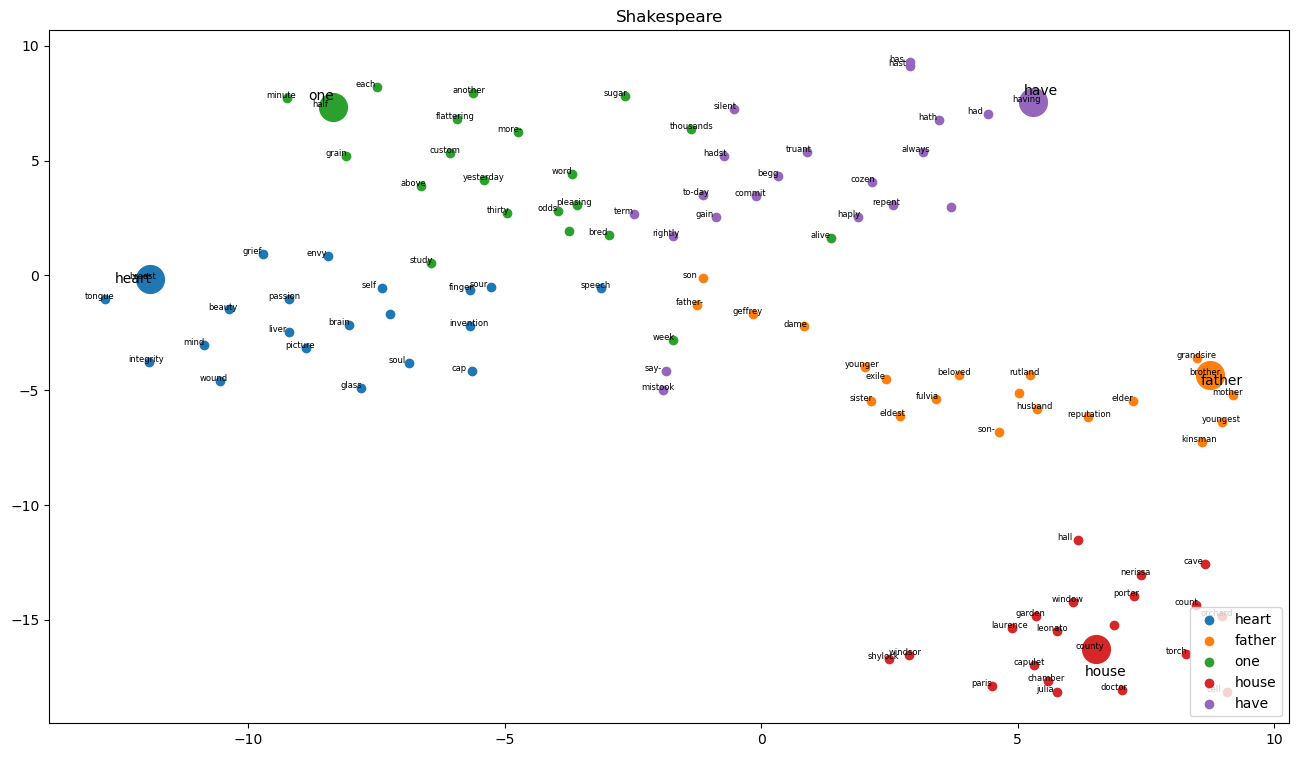

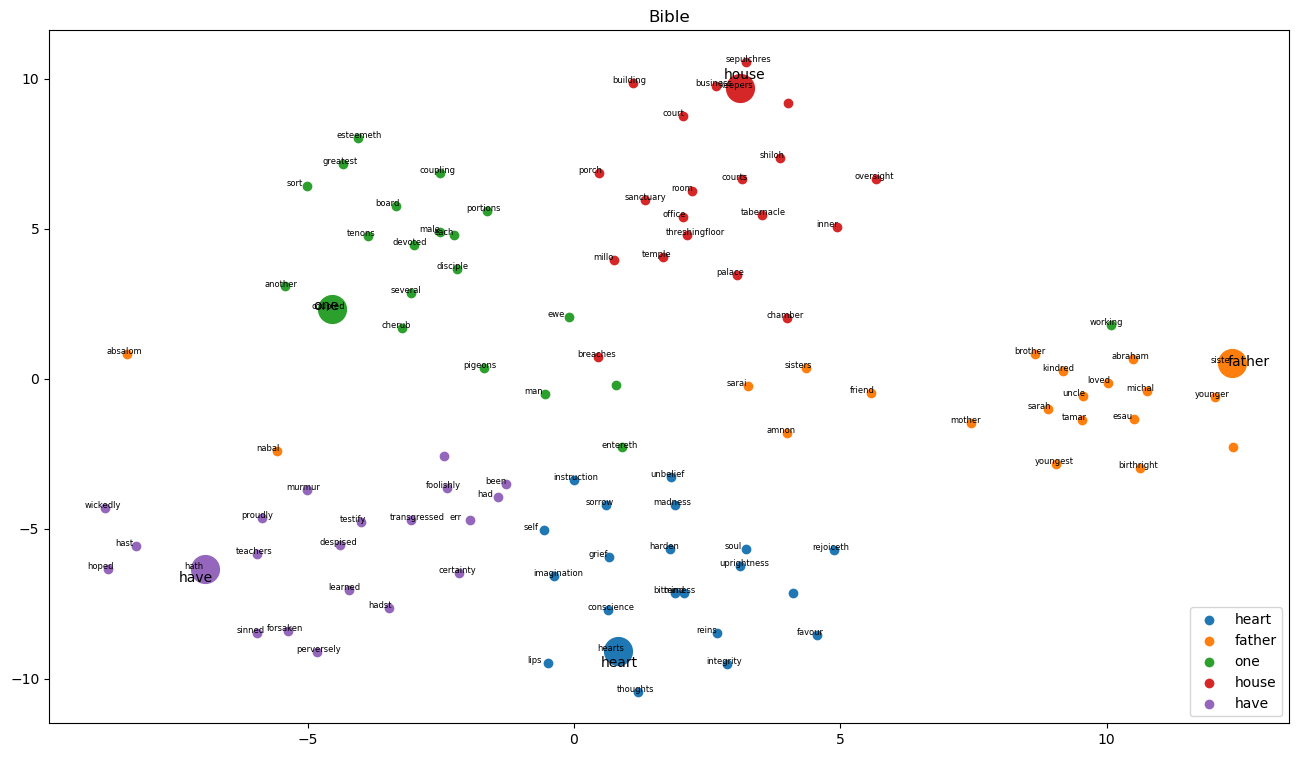

In [15]:
# Given a TSNE model trained on the embeddings of a corpus, plot the embeddings associated with each word in the keys list in different colors.
def plot_embeddings(embeddings, words, title):
    plt.figure(figsize=(16, 9))
    legend = []
    for i, label in enumerate(words):
        main_word_x = embeddings[i, 1, 0]
        main_word_y = embeddings[i, 1, 1]
        main_word = label[0]
        legend.append(main_word)
        label = label[1:]
        x = embeddings[i, :, 0]
        y = embeddings[i, :, 1]
        plt.scatter(x, y, label=main_word)
        plt.plot(main_word_x, main_word_y, marker='o', markersize=20)
        plt.annotate(main_word, (main_word_x, main_word_y), textcoords='offset points', ha='center', va='center')
        for j, txt in enumerate(label):
            plt.annotate(txt, (x[j], y[j]), textcoords='offset points', xytext=(-15,0), size=6)
    plt.legend(loc=4)
    plt.title(title)
    plt.show()

plot_embeddings(shake_embedding_cluster, shake_word_cluster, "Shakespeare")
plot_embeddings(bible_embedding_cluster, bible_word_cluster, "Bible")

## Write down your analysis:

Produce any graphs or figures that illustrate what you have found and write 2 - 3 paragraphs describing the differences you find between your two sets of embeddings and why you see them.

Generally, there are far more differences between the embeddings of the two datasets than there are similarities. In order to compare the two sets of embeddings, we began by determining some of these similarities. We did this by finding the overlap between the most frequent words in each of the corpora we utilized. This could be done by slicing each model's wv.index_to_word parameter, which holds all of the model's words ordered by frequency, and then checking the intersection between these two slices. We chose an arbitrary number of the most frequent words in each model, checked their overlap, and then chose an arbitrary set of words from that overlap to examine (based on the words having subjectively different senses or contexts that we believe they would be found in). These words were the ones we then used to look at similar word vectors and use for plotting using TSNE and PCA.

Upon creation of the arbitrary clusters, we looked at similarities of words between the clusters and found that there were only a few between a few of the clusters, displaying rather large variance between the training of the two models. These similarities can be seen above as the "cluster overlap" section. Finally, we plotted the clusters in their respective corpora's graphs to visualize them. These graphs differed in various ways; the location of the clusters were in different areas (due to the differences in the respective vector spaces of their embeddings as they have no correlation with one another) and the locations of the clusters and points relative to one another (the more relevant feature) were highly different as well. In both datasets, there were outliers among the highest similarity word clusters, but the majority clustered around the area they were supposed to.

As for the specific differences in the datasets and their clusters, we can look at the specific arbitrary words that we have chosen and the other clusters relative to them. For the Shakespeare clusters, 'heart', 'one', and 'have' all are clustered within the same general area, while the clusters for 'father' and 'house' are further away, implying greater differences in the meanings, or contexts around, these words. The Bible dataset tended to have the clusters in similar areas, with the key terms quite far away from each other. This implies that the word meanings of the most similar terms to these key terms tend to intermingle more often than the other dataset.

Cite your sources:
-------------
https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d

https://towardsdatascience.com/how-to-solve-analogies-with-word2vec-6ebaf2354009

https://radimrehurek.com/gensim/models/word2vec.html

https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.annotate.html

https://matplotlib.org/stable/api/pyplot_summary.html

Step 3: Feedforward Neural Language Model
--------------------------

### a) First, encode  your text into integers

In [16]:
# Initializing a Tokenizer
# It is used to vectorize a text corpus. Here, it just creates a mapping from 
# word to a unique index. (Note: Indexing starts from 0)
# Example:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data)
encoded = tokenizer.texts_to_sequences(data)

# Print the sequences
print(encoded)
print(tokenizer.word_index)

tokenizer_shake = Tokenizer()
tokenizer_shake.fit_on_texts(shake_split_words)
encoded_shake = tokenizer_shake.texts_to_sequences(shake_split_words)
vocab_size_shake = len(tokenizer_shake.word_index)

tokenizer_bible = Tokenizer()
tokenizer_bible.fit_on_texts(bible_split_words)
encoded_bible = tokenizer_bible.texts_to_sequences(bible_split_words)
vocab_size_bible = len(tokenizer_bible.word_index)

[[3, 4, 2, 5, 1, 6, 7], [3, 4, 2, 8, 1], [9, 10, 1], [11, 12, 1], [13, 2, 14, 1]]
{'sentence': 1, 'the': 2, 'this': 3, 'is': 4, 'first': 5, 'for': 6, 'word2vec': 7, 'second': 8, 'yet': 9, 'another': 10, 'one': 11, 'more': 12, 'and': 13, 'final': 14}


### b) Next, prepare your sequences from text

#### Fixed ngram based sequences 

In [17]:
def generate_ngram_training_samples(encoded: list, ngram:int) -> list:
    '''
    Takes the encoded data (list of lists) and 
    generates the training samples out of it.
    Parameters:
    up to you, we've put in what we used
    but you can add/remove as needed
    return: 
    list of lists in the format [[x1, x2, ... , x(n-1), y], ...]
    '''
    out_list = []
    for sent in encoded:
        i, j = 0, ngram
        while j < len(sent)+1:
            out_list.append(sent[i:j])
            i += 1
            j += 1
    return out_list

generate_ngram_training_samples(encoded, NGRAM)

[[3, 4, 2],
 [4, 2, 5],
 [2, 5, 1],
 [5, 1, 6],
 [1, 6, 7],
 [3, 4, 2],
 [4, 2, 8],
 [2, 8, 1],
 [9, 10, 1],
 [11, 12, 1],
 [13, 2, 14],
 [2, 14, 1]]

### c) Then, split the sequences into X and y and create a Data Generator

In [18]:
def separateXY(concatenated):
    '''
    Takes the encoded ngram training samples 
    and returns the X matrix and y vector for training.
    Parameters:
    concatenated - list of lists of encoded ngrams
    return: 
    np array of X and y
    '''
    X, y = [], []
    for line in concatenated:
        X.append(line[:-1])
        y.append(line[-1])
    return np.array(X), np.array(y)

In [19]:
# Note here that the sequences were in the form: 
# sequence = [x1, x2, ... , x(n-1), y]
ngram_example = generate_ngram_training_samples(encoded, NGRAM)
ngram_shake = generate_ngram_training_samples(encoded_shake, NGRAM)
ngram_bible = generate_ngram_training_samples(encoded_bible, NGRAM)

# We still need to separate it into [[x1, x2, ... , x(n-1)], ...], [y1, y2, ...]
X, y = separateXY(ngram_example)
X_shake, y_shake = separateXY(ngram_shake)
X_bible, y_bible = separateXY(ngram_bible)

# Print the first 5 samples of the input and output
print(X[:5])
print(y[:5])

[[3 4]
 [4 2]
 [2 5]
 [5 1]
 [1 6]]
[2 5 1 6 7]


In [20]:
def read_embeddings(filename: str, tokenizer: Tokenizer):
    '''Loads and parses embeddings trained in earlier.
    Parameters and return values are up to you.
    '''
    
    # you may find generating the following two dicts useful:
    # word to embedding : {'the':[0....], ...}
    # index to embedding : {1:[0....], ...} 
    # use your tokenizer's word_index to find the index of
    # a given word
    
    # Load the pre-trained embedding file
    embeddings_file = open(filename)
    
    # Initialize the embedding dictionaries
    word_to_embedding = {}
    index_to_embedding = {}
    
    i = 0
    # Loop through each line in the embeddings file
    for line in embeddings_file:
        if i == 0:
            i += 1
            continue
        # Split the line into a list of values
        values = line.split()
        #print(values)
        # The first value is the word
        word = values[0]
        #print(word)
        
        # The rest of the values are the embedding
        embedding = np.asarray(values[1:], dtype='float32')
        
        # Add the word and embedding to the dictionaries
        word_to_embedding[word] = embedding
        index_to_embedding[tokenizer.word_index[word]] = embedding
    
    # Return the dictionaries
    return word_to_embedding, index_to_embedding


In [21]:
def data_generator(X: list, y: list, num_sequences_per_batch: int, index_to_embedding: dict) -> (list,list):
    '''
    Returns data generator to be used by feed_forward
    https://wiki.python.org/moin/Generators
    https://realpython.com/introduction-to-python-generators/
    
    Yields batches of embeddings and labels to go with them.
    Use one hot vectors to encode the labels 
    (see the to_categorical function)

    '''
    if num_sequences_per_batch > len(y):
        raise Exception("Batch size must be lower than or equal to amount of data.")
    for i in range(0, len(X), num_sequences_per_batch):
        j = i + num_sequences_per_batch if i + num_sequences_per_batch <= len(X) else len(X)
        x_out = []
        y_out = to_categorical([y_item - 1 for y_item in y[i:j]], len(index_to_embedding))
        for k in range(i, j):
            x_out.append([item for x in X[k] for item in index_to_embedding[x]])
        yield (np.array(x_out), np.array(y_out))

In [22]:
# Reads in written embeddings for usage later
shake_word_to_embedding, shake_ind_to_embedding = read_embeddings('embeddings_shake.txt', tokenizer_shake)
bible_word_to_embedding, bible_ind_to_embedding = read_embeddings('embeddings_bible.txt', tokenizer_bible)

# Examples
# initialize data_generator
num_sequences_per_batch = 128 # this is the batch size
steps_per_epoch = len(X_shake)//num_sequences_per_batch  # Number of batches per epoch
train_generator = data_generator(X_shake, y_shake, num_sequences_per_batch, shake_ind_to_embedding)

# Testing time & shape of data generator output
import time
start = time.time()
sample=next(train_generator) # this is how you get data out of generators
print(sample[0].shape) # (batch_size, (n-1)*EMBEDDING_SIZE)  (128, 200)
print(sample[1].shape) # (batch_size, |V|) to_categorical
sample=next(train_generator)
sample=next(train_generator)
print(sample[0].shape) # (batch_size, (n-1)*EMBEDDING_SIZE)  (128, 200)
print(sample[1].shape)
print(time.time() - start)

(128, 400)
(128, 29476)
(128, 400)
(128, 29476)
0.03380107879638672


### d) Train your models

In [23]:
def train_model(X, y, vocab_size, ind_to_embedding, batch_size=128, hidden_units=512, epochs=1, activation='sigmoid',loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']):
    model = Sequential()
    model.add(Dense(hidden_units, activation=activation))
    model.add(Dense(vocab_size, activation='softmax'))
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    steps_per_epoch = len(X)//batch_size  # Number of batches per epoch
    train_generator = data_generator(X, y, batch_size, ind_to_embedding)

    model.fit(x=train_generator, 
          steps_per_epoch=steps_per_epoch,
          epochs=epochs,
          verbose=1)
    
    return model

In [24]:
#TODO: test new version
model_shake = train_model(X_shake, y_shake, vocab_size_shake, shake_ind_to_embedding)
model_bible = train_model(X_bible, y_bible, vocab_size_bible, bible_ind_to_embedding)

2023-03-22 19:42:00.010002: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 19:42:00.013093: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-22 19:42:00.013311: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-22 19:42:00.013394: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_nod

6204/6204 [==============================] - 77s 12ms/step - loss: 4.9106 - accuracy: 0.2010


In [25]:
model_shake.save('model_shake')
model_bible.save('model_bible')

model_shake_loaded = keras.models.load_model('model_shake')
model_bible_loaded = keras.models.load_model('model_bible')

INFO:tensorflow:Assets written to: model_shake/assets
INFO:tensorflow:Assets written to: model_bible/assets


### e) Generate Sentences

In [26]:
# generate a sequence from the model
def generate_seq(model: Sequential, 
                 tokenizer: Tokenizer, 
                 seed: list, 
                 n_words: int,
                 index_to_embedding: dict):
    '''
    Parameters:
        model: your neural network
        tokenizer: the keras preprocessing tokenizer
        seed: [w1, w2, w(n-1)]
        n_words: generate a sentence of length n_words
    Returns: string sentence
    '''
    seed = [tokenizer.word_index[word] for word in seed]
    sent = []
    non_tokenized = []
    for _ in range(n_words):
        predict = model(np.array([[item for sublist in [index_to_embedding[ind] for ind in seed] for item in sublist]]))[0]
        # strange normalization needed for np.random.choice, since 0.999999999 != 1
        p = np.asarray(predict).astype('float64')
        p /= np.sum(p)

        ind = np.random.choice(list(range(1,len(predict)+1)), p=p)
        sent.append(tokenizer.index_word[ind])
        non_tokenized.append(ind)
        seed = seed[1:] + [ind]
    return " ".join(sent), non_tokenized

### f) Compare your generated sentences

You may find it useful to run your HW 2 code on one of the datasets (or a subset of the dataset) that you used for this homework.

In [27]:
print(generate_seq(model_shake, tokenizer_shake, ["what", "you"], 20, shake_ind_to_embedding)[0])
print(generate_seq(model_bible, tokenizer_bible, ["and", "the"], 20, bible_ind_to_embedding)[0])

must no gentleman though high yourself pronounce well that is such highness to't its verges afire fearfully so profit half
unclean bread with him in the eyes of iron were on the place that are about about a transgression of


In [28]:
shannon_sents = ["<s> <s> mine own compounded of many griefs cassius of your prayers marina what canst thou tell her nurse is it not katherina love me master fenton enter fenton fenton how now son have i e la mi edg how long is it carries a brave monster indeed if one </s>",
"<s> <s> thou here and thou shalt not live to betray me to mine own valentine </s>",
"<s> <s> they in wars or whether his fall my honour lost for </s>",
"<s> <s> none at all into their hearts with humble livers in the porch caius by my troth i look d he </s>",
"<s> <s> shakes out his vacant garments with his voluptuousness full surfeits and the while exit falstaff mrs page come to visit her tell her sir for what is like an honest mind and partly by his own appeal seizes him so for in private to him and to night say i am made by th disguised pay with falsehood false <UNK> they know his humor when he sacrific d his back </s>",
"<s> <s> five flower de luce i hope thou knowest the </s>",
"<s> <s> talk desdemona my lord ham ay marry are they that </s>",
"<s> <s> bid her steal into the purse borrowing only lingers and lingers it out now please you for your execution you are the rest of this love that country girl that loves with all willingness to </s>",
"<s> <s> <UNK> english man exeunt </s>",
"<s> <s> close night doth make a good memory and yet thou <UNK> him tis cloten the south light on them go on here within </s>",
"<s> <s> penury to myself but you must be wrought ere noon upon the mart where i confess that i may miscarry in t in the frowning wrinkle of a pure blush </s>",
"<s> <s> <UNK> that stabb d and lost warwick that can not be shut and leave the rider in the prince of wales son to the <UNK> ralph prince come hither count do you busy ho need you on pandulph i will attend your presence is too foolhardy but my intents are savage wild more fierce and keen virtue preserved from fell </s>",
"<s> <s> extent upon his knees and make proud saturnine <UNK> of it a time for private <UNK> and perform an old cozening quean have i boy clown now the </s>",
"<s> <s> it most </s>",
"<s> <s> shall be king doth offer to choose a man hath recourse to her mistress is your doom choose out some light unto you i am his mine emulation hath not yet the eighth appears who bears hard his </s>",
"<s> <s> shall be in till then my name some tender of my good lord that would make her laugh at idle times as thou queen this way to lay down thy weather how goes her business that he lopp d off a little time hath founded his good judgments turn d sicilius who did hide their levity in honour s pawn engage it to a whore and keep their teeth clean so here comes my master seeks not to be sung by an </s>",
"<s> <s> himself with courtesy say st thou her maid of that thou aumerle didst send two of our attempt </s>",
"<s> <s> york suppose that i can not endure the </s>",
"<s> <s> richmond all for thee and thou shalt have as many inches is in traffic of my desires like to lose t or no or an old coat evans the <UNK> in the field as ancient writers do report </s>",
"<s> <s> fitzwater tis very strange manner brutus why this it is enacted in the tent royal of this forgetful man and farewell friends thus thisby ends adieu adieu remember me the king s </s>",
"<s> <s> give over bawd <UNK> to some more audience than a nutshell and as for the news boy aside that you are </s>",
"<s> <s> yes certain there s the second but who comes here enter vincentio to vincentio in love but a word hang no longer thus deferred </s>",
"<s> <s> absence you are o royal </s>",
"<s> <s> city he forbids it being so far d our king which </s>",
"<s> <s> must needs praise him the best heir o th story ah but some sober brow will do it but demetrius come and lead whereof who chooses his meaning chooses you will love you beg of hob and dick the first </s>"]

In [29]:
num_sentences = 50

shake_neural_sents = [generate_seq(model_shake, tokenizer_shake, tokenizer_shake.sequences_to_texts([list(random.choice(X_shake))])[0].split(), 20, shake_ind_to_embedding) for _ in range(num_sentences)]
print(shake_neural_sents)
bible_neural_sents = [generate_seq(model_bible, tokenizer_bible, tokenizer_bible.sequences_to_texts([list(random.choice(X_bible))])[0].split(), 20, bible_ind_to_embedding) for _ in range(num_sentences)]
print(bible_neural_sents)

[("it libertines she 'll not talk his honour sends so athens with ports both on forgive your side hide as", [16, 25119, 56, 58, 12, 442, 19, 177, 2048, 29, 1288, 14, 4985, 169, 43, 1267, 22, 591, 888, 26]), ("bush sadness antipholuses like a 'twixt firstlings knock from me there the force have that 'my hast done at your", [2942, 3087, 17429, 82, 6, 1270, 11733, 1144, 51, 15, 65, 1, 920, 25, 9, 3982, 189, 167, 53, 22]), ('steel to meat of it upon you warrant no pure equals into their belarius condition arm hath blushes princes swoon', [1357, 4, 1325, 5, 16, 80, 7, 580, 35, 1338, 9431, 168, 71, 1146, 1531, 573, 76, 4709, 976, 4351]), ("me though your noble the fortunes we from 'veal breath is challenge my legs are too heavens with your street", [15, 173, 22, 181, 1, 903, 38, 51, 14897, 441, 11, 1770, 8, 1326, 41, 104, 707, 14, 22, 1134]), ('katharine others lucius thereby at of despite and swear about it is prepar of less the golden stride my father', [909, 515, 377, 2781, 53, 5, 1650, 2

#### Checking for unforeseen n-grams

In [30]:
all_shake_generated_ngrams = generate_ngram_training_samples([sent[1] for sent in shake_neural_sents], 3)
all_bible_generated_ngrams = generate_ngram_training_samples([sent[1] for sent in bible_neural_sents], 3)

shake_unseen_ngrams = []
bible_unseen_ngrams = []

for i in range(num_sentences):
    if all_shake_generated_ngrams[i] not in ngram_shake:
        shake_unseen_ngrams.append([tokenizer_shake.index_word[ind] for ind in all_shake_generated_ngrams[i]])
    if all_bible_generated_ngrams[i] not in ngram_bible:
        bible_unseen_ngrams.append([tokenizer_bible.index_word[ind] for ind in all_bible_generated_ngrams[i]])

if len(shake_unseen_ngrams) >= 5:
    print("5 Shakespeare generated ngrams that were unseen in the training set:")
    print(shake_unseen_ngrams[:5])
if len(bible_unseen_ngrams) >= 5:
    print("5 Bible generated ngrams that were unseen in the training set:")
    print(bible_unseen_ngrams[:5])


5 Shakespeare generated ngrams that were unseen in the training set:
[['it', 'libertines', 'she'], ['libertines', 'she', "'ll"], ["'ll", 'not', 'talk'], ['not', 'talk', 'his'], ['talk', 'his', 'honour']]
5 Bible generated ngrams that were unseen in the training set:
[['they', 'had', 'written'], ['had', 'written', 'and'], ['written', 'and', 'not'], ['and', 'not', 'vessel'], ['not', 'vessel', 'with']]


Do your neural language models produce n-grams that were not observed during training? (1 paragraph, you may support this answer with code as desired).

As seen above, neural language models produce many (sometimes enough for full sentences) n-grams which were not observed during training. This behavior is caused by the concept of word embeddings. The model can generate words that are similar enough to another word in its word embedding training in order to attempt to convey the same meaning. Due to this, many nonsense sentences are generated with n-grams containing word embeddings of words similar to ones in the original dataset. The above code displays that this can encompass entire sentences (although it is randomly generated, so this may not necessarily occur) and that occasionally realistic sounding sentences are still generated even with newly created n-grams.

Differences between sentences:

A major difference between the two models is answered by the question above. The sentences generated by the new model may produce n-grams that have never been seen before while the Shannon's method model cannot produce never before seen n-grams. This is since Shannon's method chooses a pre-trained n-gram probabilistically (and is this constrained to learned n-grams) while the neural language model has no such restraints and must simply assign probabilities to an output label based on word embeddings (and is thus learning a likely word embedding based on the input dataset). A neural language model may assign truly anything for its output label (especially when initialized randomly or with poor training). The neural language models thus tend to seem to have poorer grammar and structure than their equivalent original n-gram language models. This may be improved using more modern NLP methods or improved in minor ways with changes to hyperparameters and training; however, for some tasks like basic sentence generation, the older models seem to generate more realistic sentences (although, as earlier stated, they have their constraints).

Sources Cited
----------------------------


https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d

https://towardsdatascience.com/how-to-solve-analogies-with-word2vec-6ebaf2354009